# Intro

Some experiments to get a good score for the [Identify Age-Related Conditions][0] kaggle competition using a neural network.

Start by importing commonly used modules that make it convenient to work with the fastai library. Some will be patched to make them work in non-standard ways but improve interactivity.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions

In [1]:
from fastai.imports import *
from fastai.tabular.all import *

# Data Inspection

Get the dataset appropriately whether we're in kaggle or not. If in kaggle, it is assumed the competition dataset has been connected to the notebook.

In [2]:
import os
competition_name = "icr-identify-age-related-conditions"

is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kaggle:
    path = Path(f"/kaggle/input/{competition_name}")
else:
    import zipfile, kaggle
    path = Path.home() / '.kaggle' / 'input' / competition_name
    kaggle.api.competition_download_cli(competition_name, path=path.parent)
    zipfile.ZipFile(f'{path}.zip').extractall(path)

icr-identify-age-related-conditions.zip: Skipping, found more recently modified local copy (use --force to force download)


Load the datasets. It's a small dataset so we can set the `low_memory` pandas flag to `False`.

In [3]:
path.ls()

(#4) [Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/test.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/greeks.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/train.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')]

In [4]:
df_train = pd.read_csv(f'{path}/train.csv', low_memory=False)
df_test = pd.read_csv(f'{path}/test.csv', low_memory=False)
df_train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [5]:
df_train.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

We can now examine the data.

In [6]:
df_train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


We see that the mean of the dependant column `Class` is much closer to zero than one. This means that the observations with a positive diagnosis are smaller in proportion in the training data. We confirm this by plotting a pie chart for column `Class`.

<Axes: ylabel='count'>

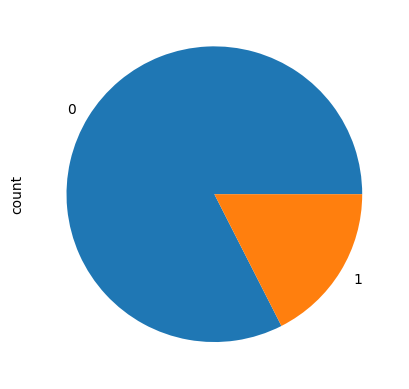

In [7]:
%matplotlib inline

df_train.Class.value_counts().plot.pie()

We also check for null values

In [8]:
df_train.isna().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

 # Data Processing
 
We'll do some simple processing. We'll replace null values with the mode of their columns, and replace the categorical columns `EJ` and `Id` with numeric codes representing their levels.

In [10]:
modes = df_train.mode().iloc[0]

def process_data(df):
    df.fillna(modes, inplace=True)
    df["EJ"] = pd.Categorical(df.EJ).codes
    df["Id"] = pd.Categorical(df.Id).codes

    
process_data(df_train)
process_data(df_test)

In [11]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    int16  
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      617 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      617 non-null    float64
 17  CC      617 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

(None, None)

# Modelling

Because of the class imbalance, we'll use stratified K-fold for our train/test splits. 

The competition uses the balanced log loss metric which is explained more [here][0]. For our purposes, we'll use the simple implementation.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/422442

In [12]:
from sklearn.metrics import log_loss
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

def m_log_loss(model, xs, y): return balanced_log_loss(np.array(y), np.array(model.predict(xs)))

For each fold, we train and validate a model and collect the metrics. However, we need to normalize the data for neural networks, and we do this using statistics over the entire training set. Since we'll use `TabularPandas`, to give us dataloaders for the neural network, we extract normalization parameters first from the entire dataset. We'll also do the same for the categorical columns to ensure each model can handle all of them.

In [13]:
ycol = "Class"
categoricals = ["EJ", "Id"]
conts = [c for c in df_train.columns if not c in categoricals + [ycol]]
procs = [Normalize, Categorify]

tabular_pd_base = TabularPandas(df_train, procs, categoricals, conts, y_names=ycol)
base_procs = tabular_pd_base.procs

In [14]:
from sklearn.model_selection import StratifiedKFold

s_kfold = StratifiedKFold(n_splits=5)

models, metrics = [], []
for train_idx, valid_idx in s_kfold.split(df_train.index, df_train[ycol]):
    
    # we'll use tabular pandas to give us a dataloader suitable for the tabular learner
    splits = (list(train_idx), list(valid_idx))
    procs = [base_procs.normalize, base_procs.categorify]
    
    tabular_pd = TabularPandas(
        df_train, procs, categoricals, conts, y_names=ycol, splits=splits, y_block=CategoryBlock
    )
    
    dataloaders = tabular_pd.dataloaders(bs=16)
    learner = tabular_learner(dataloaders, layers=[200, 100])
    
    # we previously found that 1e-2 is a suitable learning rate
    learner.fit_one_cycle(n_epoch=1, lr_max=1e-2)
    
    # get preds from validation set
    preds, targets = learner.get_preds()
    
    # append metric on validation set
    metrics.append(balanced_log_loss(targets.flatten(), preds[:,1]))
    models.append(learner)
    
models, metrics, np.mean(metrics)

epoch,train_loss,valid_loss,time
0,0.572189,0.410932,00:01


epoch,train_loss,valid_loss,time
0,0.541301,0.343022,00:01


epoch,train_loss,valid_loss,time
0,0.524409,0.427392,00:01


epoch,train_loss,valid_loss,time
0,0.511335,0.444889,00:01


epoch,train_loss,valid_loss,time
0,0.531314,0.344771,00:01


([<fastai.tabular.learner.TabularLearner at 0x7f6a6dcc9820>,
 [0.4827545556354566,
  0.3976927391946501,
  0.5118919508157265,
  0.6263020770278497,
  0.4321149529575001],
 0.4901512551262366)

Experiments seem to show that `fit_one_cycle` with 1 epochs give the best score. Any more epochs and it tends to overfit the training sets.

We now have an ensemble of decision trees. We can evaluate them by calculating the average metric.

It doesn't seem to negatively impact the score

# Submission

We can submit this to kaggle and see how it scores on the leaderboard. We'll get predictions from the ensemble by averaging all the predictions from the individual neural nets.

In [15]:
preds = []
for learner in models:
    test_dl = learner.dls.test_dl(df_test)
    preds.append(learner.get_preds(dl=test_dl))
preds = [p for p, _ in preds]

avg_preds = torch.stack(preds).mean(axis=0)
df_submission = pd.read_csv(f"{path}/sample_submission.csv")
df_submission[["class_0", "class_1"]] = avg_preds
df_submission

,Id,class_0,class_1
0,00eed32682bb,0.341797,0.658203
1,010ebe33f668,0.341586,0.658414
2,02fa521e1838,0.346266,0.653734
3,040e15f562a2,0.347123,0.652877
4,046e85c7cc7f,0.339950,0.660050


In [16]:
submit=False
if is_kaggle and submit:
    df_submission.to_csv("submission.csv", index=False)

This one scored 0.35, worse than 0.33, our best so far.

# Important columns

We next see whether using only the important columns as previously identified by the random forest will have a noticeable impact.

In [17]:
important_columns = ['DU','FL','DA','GL','CR','DI','AB','DE','EH','BC','FD ','FR','AF','CC','EE','FE','DH','FI','AM','DL','BR','EB','CD ','CU','BN','DY','BP','BQ','GH','AX','CF','GF','CB','GB','EG','FC']

They don't include any categorical columns, so we can skip categorification.

We define a function to give us the neural network kfold ensemble.

In [18]:
def nn_kfold(df, conts=None, categoricals=None, procs=None):
    models, metrics = [], []
    for train_idx, valid_idx in s_kfold.split(df.index, df[ycol]):
    
        # we'll use tabular pandas to give us a dataloader suitable for the tabular learner
        splits = (list(train_idx), list(valid_idx))
        
        tabular_pd = TabularPandas(
            df, procs, cont_names=conts, cat_names=categoricals, y_names=ycol, splits=splits, y_block=CategoryBlock
        )

        dataloaders = tabular_pd.dataloaders(bs=16)
        learner = tabular_learner(dataloaders, layers=[200, 100])

        # we previously found that 1e-2 is a suitable learning rate
        learner.fit_one_cycle(n_epoch=1, lr_max=1e-2)

        # get preds from validation set
        preds, targets = learner.get_preds()

        # append metric on validation set
        metrics.append(balanced_log_loss(targets.flatten(), preds[:,1]))
        models.append(learner)

    return models, metrics, np.mean(metrics)

Test it with all columns..

In [19]:
_, _, score = nn_kfold(df_train, conts, categoricals, procs)
score

epoch,train_loss,valid_loss,time
0,0.536020,0.560833,00:01


epoch,train_loss,valid_loss,time
0,0.531551,0.405170,00:02


epoch,train_loss,valid_loss,time
0,0.506411,0.657291,00:02


epoch,train_loss,valid_loss,time
0,0.517465,0.377879,00:02


epoch,train_loss,valid_loss,time
0,0.537455,0.419697,00:02


0.6661611708695337

And then we try it with only the important columns, which are all continuous variables.

In [20]:
tabular_pd_base = TabularPandas(df_train, procs=[Normalize], cont_names=important_columns, y_names=ycol)

In [21]:
nn_ensemble, metrics, avg_metric = nn_kfold(df_train[important_columns + [ycol]], conts=important_columns, procs=tabular_pd_base.procs.normalize)
avg_metric

epoch,train_loss,valid_loss,time
0,0.591471,0.365842,00:01


epoch,train_loss,valid_loss,time
0,0.541842,0.382600,00:01


epoch,train_loss,valid_loss,time
0,0.506979,0.479738,00:01


epoch,train_loss,valid_loss,time
0,0.531445,0.436921,00:01


epoch,train_loss,valid_loss,time
0,0.566232,0.362344,00:01


0.518101816196497

Limiting it to only important columns doesn't seem to have a negative effect.

# Ensembling the random forests with neural networks

We can also create a random forest ensemble using kfold and use the overall average predictions of the ensemble as the final predictions.

In [22]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(xs, y, n_estimators=300, max_samples=None, max_features="sqrt", min_samples_leaf=1, **kwargs):
    return RandomForestClassifier(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        **kwargs
    ).fit(xs, y)

def x_y(df):
    y = df[ycol]
    x = df.drop(columns=ycol)
    return x, y

In [23]:
def rf_kfold(df):
    
    models, metrics = [], []
    for train_idx, valid_idx in s_kfold.split(df.index, df.Class):
        train_xy, valid_xy = df.iloc[train_idx], df.iloc[valid_idx]
        train_x, train_y = x_y(train_xy)
        valid_x, valid_y = x_y(valid_xy)
    
        rf = random_forest(train_x, train_y, oob_score=True)
        oob_preds = rf.oob_decision_function_
        oob_preds_class_1 = oob_preds[:,1]
    
        metrics.append(balanced_log_loss(train_y, oob_preds_class_1))
        
        models.append(rf)
    
    return models, metrics, np.mean(metrics)

rf_ensemble, metrics, avg_metric = rf_kfold(df_train[important_columns + [ycol]])
avg_metric

0.48452259536338593

Next, let's get the average predictions on the test data using the random forest ensemble.

In [24]:
preds = []
for rf in rf_ensemble:
    preds.append(rf.predict_proba(df_test[important_columns]))

avg_rf_preds = np.stack(preds).mean(axis=0)
avg_rf_preds

array([[0.526, 0.474],
       [0.526, 0.474],
       [0.526, 0.474],
       [0.526, 0.474],
       [0.526, 0.474]])

And the same for neural net predictions.

In [25]:
preds = []
for learner in nn_ensemble:
    test_dl = learner.dls.test_dl(df_test[important_columns])
    preds.append(learner.get_preds(dl=test_dl))
preds = [p for p, _ in preds]
avg_nn_preds = torch.stack(preds).mean(axis=0)
avg_nn_preds

tensor([[0.4442, 0.5558],
        [0.4442, 0.5558],
        [0.4442, 0.5558],
        [0.4442, 0.5558],
        [0.4442, 0.5558]])

Average the two to find the overall predictions.

In [26]:
avg_preds = (avg_rf_preds + avg_nn_preds.numpy()) / 2
avg_preds

array([[0.48511197, 0.514888  ],
       [0.48511197, 0.514888  ],
       [0.48511197, 0.514888  ],
       [0.48511197, 0.514888  ],
       [0.48511197, 0.514888  ]])

# Submission

In [27]:
df_submission = pd.read_csv(f"{path}/sample_submission.csv")
df_submission[["class_0", "class_1"]] = avg_preds
df_submission

,Id,class_0,class_1
0,00eed32682bb,0.485112,0.514888
1,010ebe33f668,0.485112,0.514888
2,02fa521e1838,0.485112,0.514888
3,040e15f562a2,0.485112,0.514888
4,046e85c7cc7f,0.485112,0.514888


In [28]:
submit=True
if is_kaggle and submit:
    df_submission.to_csv("submission.csv", index=False)